# NF

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
import pandas as pd

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [11]:
from model.dgl.NF import NF

AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = NF(
        task_type="regression",
        # NF Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64],
        max_degree=10,
        activation=torch.nn.functional.relu,
        batchnorm=True,
        dropout=0.015713745299991422,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.003302744322396134,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=500, min_epoch=100, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 26%|██▌       | 131/500 [00:10<00:28, 12.84it/s, loss: 0.036 rmse: 1.291]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 28%|██▊       | 142/500 [00:12<00:30, 11.61it/s, loss: 0.043 rmse: 1.231]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 31%|███       | 155/500 [00:12<00:28, 12.06it/s, loss: 0.045 rmse: 0.985]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 34%|███▍      | 169/500 [00:13<00:25, 12.78it/s, loss: 0.035 rmse: 1.019]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 36%|███▌      | 180/500 [00:15<00:26, 11.86it/s, loss: 0.033 rmse: 0.918]


In [12]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [13]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 1.144507935854444
TST : R^2 0.2889329056726515


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (NF)\nRMSE: 1.145, $R^2$: 0.289')

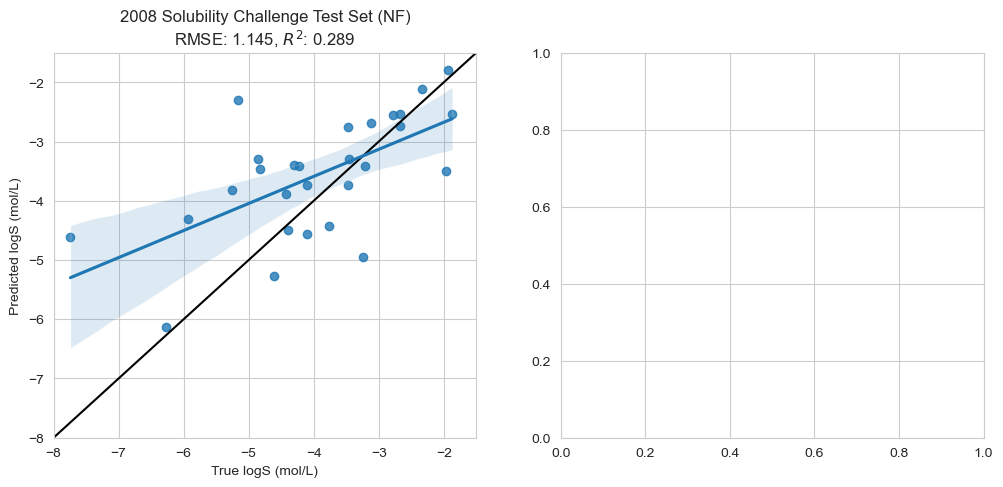

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "NF"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")